<a href="https://colab.research.google.com/github/willdata0101/UT-Austin-ML-AI-Projects/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing libraries
!pip install contractions
!pip install vaderSentiment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from random import randint, uniform
from scipy.stats import truncnorm, loguniform

from bs4 import BeautifulSoup
import unicodedata
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
import spacy
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import RandomizedSearchCV

     |████████████████████████████████| 266kB 20.4MB/s 
     |████████████████████████████████| 327kB 45.8MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85395 sha256=8c2f5e652f318f08f9842481956c26e19eb186a3f6f228b994942c0763c65711
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 133kB 18.3MB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Importing dataset

data = pd.read_csv('Tweets.csv')

In [ ]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Print shape of data

data.shape

(14640, 15)

In [ ]:
# Data description

data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


In [ ]:
# Drop all cols except 'text' and 'airline_sentiment'

data = data[['text', 'airline_sentiment']]

In [ ]:
data

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [ ]:
# Check shape of data

data.shape

(14640, 2)

In [ ]:
# Print first 5 rows

data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14640 non-null  object
 1   airline_sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [ ]:
# VADER Analysis of tweets with hashtags vs. without hashtags

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sent_analyzer = SentimentIntensityAnalyzer()

substring = '???'

hash_text = [text for text in data['text'] if substring in text]

hash_text[:11]

['@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???',
 '@VirginAmerica seriously, though. will there not be direct flights from SFO-FLL in may???',
 "@united ZCC82U Cancelled Flight flight 16h in advance??? Need connect flight reschedule so the link isn't helping. Help!? Gf waited months to see me.",
 "@united ok. To top things off, you've lost my luggage. Could you get ANY worse??? #UnitedAirlines",
 '@United flight delayed-no one remembered to turn the heat on flight 559 leaving ORD-seriously???',
 '@united LHR arrival lounge #fail. Waited 20 mins for shower then left to find hotel. U know how many passengers u carry. Planning???',
 '@united  gate agent at EWR " if you are disabled or in a wheel chair, it\'s time to board, please step". STEP UP??? Lol',
 "@united looks like today will be my 6th consecutive delayed flight from you...do I win a prize??? @Southwest Air why don't you fly to SBA? 😭",
 '@unite

In [ ]:
neg_scores = 0
neu_scores = 0
pos_scores = 0

scores_dict_with = {}

for text in hash_text:
  scores_dict_with[text] = sent_analyzer.polarity_scores(text)
  neg_scores = sum(i['neg'] >= 0.5 for i in scores_dict_with.values())
  neu_scores = sum(i['neu'] >= 0.5 for i in scores_dict_with.values())
  pos_scores = sum(i['pos'] >= 0.5 for i in scores_dict_with.values())

print("With hashtags:")

print("Negative score count:", neg_scores)
print("Neutral score count:", neu_scores)
print("Positive score count:", pos_scores)

neg_scores_wo = 0
neu_scores_wo = 0
pos_scores_wo = 0

data_wo_hash = data['text'].copy()

data_wo_hash = [text for text in data_wo_hash if substring not in data_wo_hash]

scores_dict_without = {}

for text in data['text']:
  scores_dict_without[text] = sent_analyzer.polarity_scores(text)
  neg_scores_wo = sum(i['neg'] >= 0.5 for i in scores_dict_without.values())
  neu_scores_wo = sum(i['neu'] >= 0.5 for i in scores_dict_without.values())
  pos_scores_wo = sum(i['pos'] >= 0.5 for i in scores_dict_without.values())

print()
print("Without hashtags:")
print("Negative score count:", neg_scores_wo)
print("Neutral score count:", neu_scores_wo)
print("Positive score count:", pos_scores_wo)


With hashtags:
Negative score count: 1
Neutral score count: 129
Positive score count: 1

Without hashtags:
Negative score count: 54
Neutral score count: 13453
Positive score count: 640


In [ ]:
# Text Pre-processing

# Remove HTML tags

def strip_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  clean_text = soup.get_text()
  return clean_text

# Before clean

In [ ]:
data['text'] = [strip_tags(text) for text in data['text']]

In [ ]:
data['text'].head(40)

0                   @VirginAmerica What @dhepburn said.
1     @VirginAmerica plus you've added commercials t...
2     @VirginAmerica I didn't today... Must mean I n...
3     @VirginAmerica it's really aggressive to blast...
4     @VirginAmerica and it's a really big bad thing...
5     @VirginAmerica seriously would pay $30 a fligh...
6     @VirginAmerica yes, nearly every time I fly VX...
7     @VirginAmerica Really missed a prime opportuni...
8       @virginamerica Well, I didn't…but NOW I DO! :-D
9     @VirginAmerica it was amazing, and arrived an ...
10    @VirginAmerica did you know that suicide is th...
11    @VirginAmerica I <3 pretty graphics. so much b...
12    @VirginAmerica This is such a great deal! Alre...
13    @VirginAmerica @virginmedia I'm flying your #f...
14                               @VirginAmerica Thanks!
15        @VirginAmerica SFO-PDX schedule is still MIA.
16    @VirginAmerica So excited for my first cross c...
17    @VirginAmerica  I flew from NYC to SFO las

In [ ]:
# Cleaning the text

def exp_cont(text):
  return contractions.fix(text)

for i, row in data.iterrows():
  text = data.at[i, 'text']
  text = exp_cont(text)
  data.at[i, 'text'] = text

In [ ]:
# Tokenization

def tokenize(text):
  tokenizer = ToktokTokenizer()
  for w in text:
    tokens = tokenizer.tokenize(text)
    return tokens

data['text'] = data['text'].apply(tokenize)

data['text']

0               [@VirginAmerica, What, @dhepburn, said, .]
1        [@VirginAmerica, plus, you, have, added, comme...
2        [@VirginAmerica, I, did, not, today, ..., Must...
3        [@VirginAmerica, it, is, really, aggressive, t...
4        [@VirginAmerica, and, it, is, a, really, big, ...
                               ...                        
14635    [@AmericanAir, thank, you, we, got, on, a, dif...
14636    [@AmericanAir, leaving, over, 20, minutes, Lat...
14637    [@AmericanAir, Please, bring, American, Airlin...
14638    [@AmericanAir, you, have, my, money, ,, you, c...
14639    [@AmericanAir, we, have, 8, ppl, so, we, need,...
Name: text, Length: 14640, dtype: object

In [ ]:
# Removal of special characters, punctuation, and numbers

def remove_characters(text):
  text = str(text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  return text

data['text'] = [remove_characters(text) for text in data['text']]

In [ ]:
data['text'].head()

0                    VirginAmerica What dhepburn said 
1    VirginAmerica plus you have added commercials ...
2    VirginAmerica I did not today  Must mean I nee...
3    VirginAmerica it is really aggressive to blast...
4    VirginAmerica and it is a really big bad thing...
Name: text, dtype: object

In [ ]:
# Conversion to lowercase

data['text'] = [text.lower() for text in data['text']]

In [ ]:
data['text'].head()

0                    virginamerica what dhepburn said 
1    virginamerica plus you have added commercials ...
2    virginamerica i did not today  must mean i nee...
3    virginamerica it is really aggressive to blast...
4    virginamerica and it is a really big bad thing...
Name: text, dtype: object

In [ ]:
# Removing stopwords

stopword_list = stopwords.words('english')

stopword_list.remove('no')
stopword_list.remove('not')

data['text'] = [word for word in data['text'] if word not in stopword_list]

In [ ]:
# Lemmatization with Spacy

nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

data['text'] = [lemmatize(text) for text in data['text']]

In [ ]:
data['text'].head()

0                      virginamerica what dhepburn say
1    virginamerica plus you have add commercial to ...
2    virginamerica i do not today   must mean i nee...
3    virginamerica it be really aggressive to blast...
4    virginamerica and it be a really big bad thing...
Name: text, dtype: object

In [ ]:
# Vectorization with CountVectorizer

text = data['text']

vectorizer = CountVectorizer()

vect = vectorizer.fit_transform(text)

In [ ]:
vect.shape

(14640, 12142)

In [ ]:
train_array = vect.toarray()

In [ ]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_array, data['airline_sentiment'], test_size=0.3, random_state=1)

In [ ]:
# Building Random Forest model

rf = RandomForestClassifier()

model_params = {
    'n_estimators': [randint(5, 500)],
    'max_depth': [randint(10, 100)]
}

random_search = RandomizedSearchCV(rf, model_params, n_iter=1, cv=5, random_state=1, n_jobs=-1, verbose=True)

rs_model = random_search.fit(X_train, y_train)

from pprint import pprint
pprint(rs_model.best_params_)

In [ ]:
rf = RandomForestClassifier(max_depth=42, n_estimators=253, verbose=True, random_state=1)

rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:  1.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=42, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=253,
                       n_jobs=None, oob_score=False, random_state=1,
                       verbose=True, warm_start=False)

In [ ]:
# Accuracy score

y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 253 out of 253 | elapsed:    0.6s finished


In [ ]:
print("Accuracy for CountVectorizer: ", acc)

Accuracy for CountVectorizer:  0.7033242258652095


In [ ]:
# Evaluating model

cv_score = np.mean(cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1, verbose=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


In [ ]:
print("Cross-validation score for CountVectorizer is: %.2f " % cv_score)

Cross-validation score for CountVectorizer is: 0.70 


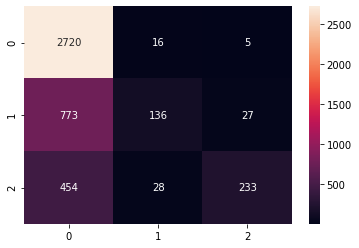

In [ ]:
# Confusion Matrix for CountVectorizer

cm = confusion_matrix(y_test, y_pred)

sb.heatmap(cm, annot=True, fmt='.0f')

In [ ]:
# Vectorization with TF-IDF Vectorizer

vectorizer_tf = TfidfVectorizer()

In [ ]:
vect_tf = vectorizer_tf.fit_transform(text)

In [ ]:
vect_tf.shape

(14640, 12142)

In [ ]:
vect_tf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Building Random Forest model

rf_tf = RandomForestClassifier(verbose=True, n_estimators=992, max_depth=42, criterion='entropy', n_jobs=-1)

In [ ]:
rf_tf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:   13.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=42, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=253,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=True, warm_start=False)

In [ ]:
# Accuracy

y_pred_tf = rf_tf.predict(X_test)

acc_tf = accuracy_score(y_test, y_pred)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 253 out of 253 | elapsed:    0.5s finished


In [ ]:
print("Accuracy for TF-IDF Vectorizer:", acc_tf)

Accuracy for TF-IDF Vectorizer: 0.7033242258652095


In [ ]:
# Evaluating model

cv_score_tf = np.mean(cross_val_score(rf_tf, X_train, y_train, cv=5))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 992 out of 992 | elapsed:  4.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 992 out of 992 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   52.2s
[Parallel(n

In [ ]:
print("Cross-validation score for TF-IDF Vectorizer is: %.2f " % cv_score_tf)

Cross-validation score for TF-IDF Vectorizer is: 0.71 


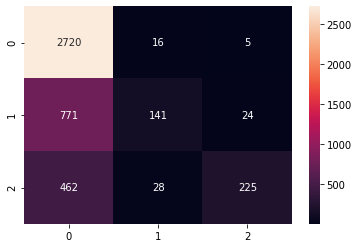

In [ ]:
b# Confusion Matrix for TF-IDF Vectorizer

cm = confusion_matrix(y_test, y_pred_tf)

sb.heatmap(cm, annot=True, fmt='.0f')

In [ ]:
# Creating dataframe of predictions

predict = rf_tf.predict(vect_tf)

data_dict = {"Text": data['text'], "True Sentiment": data['airline_sentiment'], "Predicted Sentiment": predict}

sents_data = pd.DataFrame(data_dict)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 992 out of 992 | elapsed:    2.0s finished


In [ ]:
sents_data[sents_data['Predicted Sentiment'] == sents_data['True Sentiment']]

,Text,True Sentiment,Predicted Sentiment
3,virginamerica it be really aggressive to blast...,negative,negative
4,virginamerica and it be a really big bad thing...,negative,negative
5,virginamerica seriously would pay a flight ...,negative,negative
14,virginamerica thank,positive,positive
15,virginamerica sfopdx schedule be still mia,negative,negative
...,...,...,...
14631,americanair thx for nothing on get us out of t...,negative,negative
14633,americanair my flight be cancel flightle lea...,negative,negative
14634,americanair right on cue with the delay,negative,negative
14636,americanair leave over minute late flight no...,negative,negative


In [ ]:
true_len = int(sents_data[sents_data['Predicted Sentiment'] == sents_data['True Sentiment']].count()[0])
total_len = int(sents_data.count()[0])

true_rate = true_len/total_len

In [ ]:
print("Percentage of correctly predicted sentiments: %.2f" % true_rate)

Percentage of correctly predicted sentiments: 0.64


###Conclusion

Various methodologies, including text pre-processing and vectorization, allow machine learning models to perform sentiment analysis, that is, whether a text is negative, neutral, or positive. In this project, a dataset of tweets was pre-processed, removing HTML tags, numbers, and special characters, tokenizing, and lemmatizing, which facilitates transforming the text data into numpy arrays, then vectors. Vectorizers, such as TF-IDF Vectorizer, normalize or balance out the weights for each word, so that common words such as "the" do not outweigh more important, less frequent words.

The ML algorithm used in this project was the Random Forest Classifier. Hyperparameter tuning was performed on "n_estimators" and "max_depth", which after trial and error reached an accuracy of around 0.7, confirmed by the cross-validation score. Running the entire dataset as a vector through the final model resulted in 64% of the tweets being classified with the correct sentiment. Technical problems hindered progress in improving the model, but further hyperparameter tuning would likely result in higher accuracy.